# Quantum Amplitude Estimation (QAE)

Is the task of finding an estimate for the amplitude a of the state |Psi_1>. This task has first been investigated by Brassard in 2000, and their algorithm uses a combination of the Grover operator

On a quantum computer, we can model this operator with a rotation around the -axis of a single qubit.

We’ll fix the probability we want to estimate to probability 0.2

In [1]:
p = 0.2

Now we can define circuits for *A* and *Q*.

In [2]:
import numpy as np
from qiskit.circuit import QuantumCircuit


class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)


class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k

In [3]:
A = BernoulliA(p)
Q = BernoulliQ(p)

## Qiskit’s Amplitude Estimation Workflow

Qiskit implements several QAE algorithms that all derive from the `AmplitudeEstimator` interface. In the initializer we specify algorithm specific settings and the `estimate` method, which does all the work, takes an `EstimationProblem` as input and returns an `AmplitudeEstimationResul`t object. Since all QAE variants follow the same interface, we can use them all to solve the same problem instance.

Next, we’ll run all different QAE algorithms. To do so, we first define the estimation problem which will contain the *A* and *Q* operators as well as how to identify the |Psi_1> state, which in this simple example is just |1>.

In [4]:
from qiskit.algorithms import EstimationProblem

problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


To execute circuits we’ll use Qiskit’s statevector simulator.

In [5]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance

backend = BasicAer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend)

### Canonical AE

Now let’s solve this with the original QAE implementation by Brassard et al.
With the algorithm defined, we can call the estimate method and provide it with the problem to solve.

In [6]:
from qiskit.algorithms import AmplitudeEstimation

ae = AmplitudeEstimation(
    num_eval_qubits=3,  # the number of evaluation qubits specifies circuit width and accuracy
    quantum_instance=quantum_instance,
)

ae_result = ae.estimate(problem)

print(ae_result.estimation)

0.1464466


We see that this is not a very good estimate for our target of `p=0.2`! That’s due to the fact the canonical AE is restricted to a discrete grid, specified by the number of evaluation qubits:

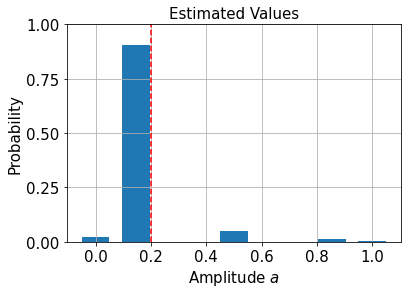

Interpolated MLE estimator: 0.19999999390907777


In [7]:
import matplotlib.pyplot as plot

# plot estimated values
gridpoints = list(ae_result.samples.keys())
probabilities = list(ae_result.samples.values())
width = 0.5 / len(probabilities)

plot.bar(gridpoints, probabilities, width=width)
plot.axvline(p, color="r", ls="--")
plot.xticks(size=15)
plot.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plot.title("Estimated Values", size=15)
plot.ylabel("Probability", size=15)
plot.xlabel(r"Amplitude $a$", size=15)
plot.ylim((0,1))
plot.grid()
plot.show()

print("Interpolated MLE estimator:", ae_result.mle)

To improve the estimate we can interpolate the measurement probabilities and compute the maximum likelihood estimator that produces this probability distribution. We can have a look at the circuit that AE executes:

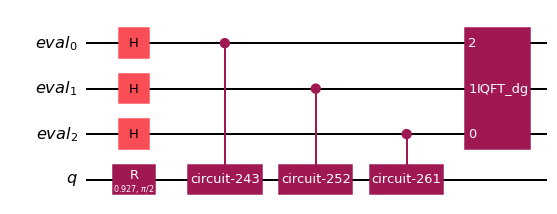

In [8]:
ae_circuit = ae.construct_circuit(problem)

# decompose 1 level: exposes the Phase estimation circuit!
ae_circuit.decompose().draw("mpl", style="iqx")

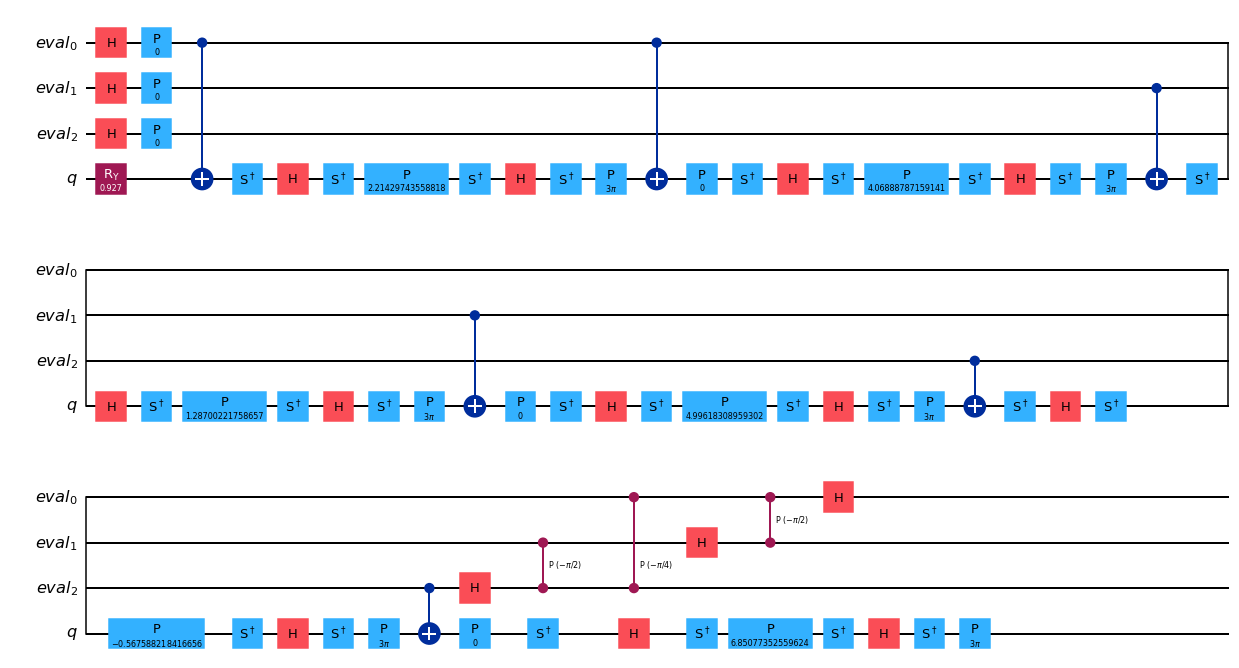

In [9]:
from qiskit import transpile

basis_gates = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
transpile(ae_circuit, basis_gates=basis_gates, optimization_level=2).draw("mpl", style="iqx")

### Iterative Amplitude Estimation

The circuits here only consist of Grover powers and are much cheaper!

Estimate: 0.19999999999999998


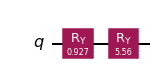

In [10]:
from qiskit.algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01, # target accuracy
    alpha=0.05, # width of the confidence interval
    quantum_instance=quantum_instance,
)
iae_result = iae.estimate(problem)

print("Estimate:", iae_result.estimation)

iae_circuit = iae.construct_circuit(problem, k=3)
iae_circuit.draw("mpl", style="iqx")

### Maximum Likelihood Amplitude Estimation

In [11]:
from qiskit.algorithms import MaximumLikelihoodAmplitudeEstimation

mlae = MaximumLikelihoodAmplitudeEstimation(
    evaluation_schedule=3, quantum_instance=quantum_instance #log2 of the maximal Grover power
)
mlae_result = mlae.estimate(problem)

print("Estimate:", mlae_result.estimation)

Estimate: 0.20002237175368104


### Faster Amplitude Estimation

Note: https://quantumcomputing.stackexchange.com/questions/16182/is-there-an-issue-preventing-people-from-scaling-grovers-algorithm-to-larger-nu

In [12]:
from qiskit.algorithms import FasterAmplitudeEstimation

fae = FasterAmplitudeEstimation(
    delta=0.01, # target accuracy
    maxiter=3,
    quantum_instance=quantum_instance,
)
fae_result = fae.estimate(problem)

print("Estimate:", fae_result.estimation)

Estimate: 0.20000000000000018


/opt/conda/lib/python3.8/site-packages/qiskit/algorithms/amplitude_estimators/estimation_problem.py:194: UserWarning: Rescaling discards the Grover operator.
  warnings.warn("Rescaling discards the Grover operator.")


## References

[1] Quantum Amplitude Amplification and Estimation. Brassard et al (2000). https://arxiv.org/abs/quant-ph/0005055

[2] Iterative Quantum Amplitude Estimation. Grinko, D., Gacon, J., Zoufal, C., & Woerner, S. (2019). https://arxiv.org/abs/1912.05559

[3] Amplitude Estimation without Phase Estimation. Suzuki, Y., Uno, S., Raymond, R., Tanaka, T., Onodera, T., & Yamamoto, N. (2019). https://arxiv.org/abs/1904.10246

[4] Faster Amplitude Estimation. K. Nakaji (2020). https://arxiv.org/pdf/2003.02417.pdf